# Manipulating GPflow models

One of the key ingredients in GPflow is the model class, which enables you to carefully control parameters. This notebook shows how some of these parameter control features work, and how to build your own model with GPflow. First we'll look at:

 - how to view models and parameters
 - how to set parameter values
 - how to constrain parameters (for example, variance > 0)
 - how to fix model parameters
 - how to apply priors to parameters
 - how to optimize models

Then we'll show how to build a simple logistic regression model, demonstrating the ease of the parameter framework. 

GPy users should feel right at home, but there are some small differences.

First, let's deal with the usual notebook boilerplate and make a simple GP regression model. See [Basic (Gaussian likelihood) GP regression model](../basics/regression.ipynb) for specifics of the model; we just want some parameters to play with.

In [1]:
import numpy as np
import gpflow
import tensorflow_probability as tfp
from gpflow.utilities import print_summary, set_trainable, to_default_float

We begin by creating a very simple GP regression model:

In [2]:
# generate toy data
np.random.seed(1)
X = np.random.rand(20, 1)
Y = np.sin(12 * X) + 0.66 * np.cos(25 * X) + np.random.randn(20,1) * 0.01

m = gpflow.models.GPR((X, Y), kernel=gpflow.kernels.Matern32() + gpflow.kernels.Linear())

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


## Viewing, getting, and setting parameters
You can display the state of the model in a terminal by using `print_summary(m)`. You can change the display format using the `fmt` keyword argument, e.g. `'html'`. In a notebook, you can also use `fmt='notebook'` or set the default printing format as `notebook`:

In [3]:
print_summary(m, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + AffineScalar,,True,(),float64,1


In [4]:
gpflow.config.set_default_summary_fmt("notebook")

This model has four parameters. The kernel is made of the sum of two parts. The first (counting from zero) is a Matern32 kernel that has a variance parameter and a lengthscale parameter; the second is a linear kernel that has only a variance parameter. There is also a parameter that controls the variance of the noise, as part of the likelihood. 

All the model variables have been initialized at `1.0`. You can access individual parameters in the same way that you display the state of the model in a terminal; for example, to see all the parameters that are part of the likelihood, run:

In [5]:
print_summary(m.likelihood)

name,class,transform,prior,trainable,shape,dtype,value
Gaussian.variance,Parameter,Softplus + AffineScalar,,True,(),float64,1


This gets more useful with more complex models!

To set the value of a parameter, just use `assign()`:

In [6]:
m.kernel.kernels[0].lengthscale.assign(0.5)
m.likelihood.variance.assign(0.01)
print_summary(m, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,0.5
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + AffineScalar,,True,(),float64,0.01


## Constraints and trainable variables

GPflow helpfully creates an unconstrained representation of all the variables. In the previous example, all the variables are constrained positively (see the **transform** column in the table); the unconstrained representation is given by $\alpha = \log(\exp(\theta)-1)$. The `trainable_parameters` property returns the constrained values:

In [7]:
m.trainable_parameters

(<tf.Tensor: id=160, shape=(), dtype=float64, numpy=0.5>,
 <tf.Tensor: id=162, shape=(), dtype=float64, numpy=1.0>,
 <tf.Tensor: id=164, shape=(), dtype=float64, numpy=1.0>,
 <tf.Tensor: id=167, shape=(), dtype=float64, numpy=0.009999999776482686>)

Each parameter has an `unconstrained_variable` attribute that enables you to access the unconstrained value as a TensorFlow `Variable`.

In [8]:
p = m.kernel.kernels[0].lengthscale
p.unconstrained_variable

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.43275212956718856>

You can also check the unconstrained value as follows:

In [9]:
p.transform.inverse(p)

<tf.Tensor: id=169, shape=(), dtype=float64, numpy=-0.43275212956718856>

Constraints are handled by the Bijector classes from the `tensorflow_probability` package. You might prefer to use the constraint $\alpha = \log(\theta)$; this is easily done by replacing the parameter with one that has a different `transform` attribute (here we make sure to copy all other attributes across from the old parameter; this is not necessary when there is no `prior` and the `trainable` state is still the default of `True`):

In [10]:
old_parameter = m.kernel.kernels[0].lengthscale
new_parameter = gpflow.Parameter(old_parameter,
                                 trainable=old_parameter.trainable,
                                 prior=old_parameter.prior,
                                 name=old_parameter.name.split(':')[0],  # tensorflow is weird and adds ':0' to the name
                                 transform=tfp.bijectors.Exp())
m.kernel.kernels[0].lengthscale = new_parameter

Though the lengthscale itself remains the same, the unconstrained lengthscale has changed:

In [11]:
p.transform.inverse(p)

<tf.Tensor: id=181, shape=(), dtype=float64, numpy=-0.43275212956718856>

You can also change the `transform` attribute in place:

In [12]:
m.kernel.kernels[0].variance.transform = tfp.bijectors.Exp()

In [13]:
print_summary(m, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Exp,,True,(),float64,1
GPR.kernel.kernels[0].lengthscale,Parameter,Exp,,True,(),float64,0.5
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + AffineScalar,,True,(),float64,0.01


## Changing whether a parameter will be trained in optimization

Another helpful feature is the ability to fix parameters. To do this, simply set the `trainable` attribute to `False`; this is shown in the **trainable** column of the representation, and the corresponding variable is removed from the free state.

In [14]:
m.kernel.kernels[1].variance.trainable = False
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Exp,,True,(),float64,1
GPR.kernel.kernels[0].lengthscale,Parameter,Exp,,True,(),float64,0.5
GPR.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + AffineScalar,,True,(),float64,0.01


In [15]:
m.trainable_parameters

(<tf.Tensor: id=206, shape=(), dtype=float64, numpy=0.5>,
 <tf.Tensor: id=208, shape=(), dtype=float64, numpy=1.0>,
 <tf.Tensor: id=211, shape=(), dtype=float64, numpy=0.009999999776482686>)

To unfix a parameter, just set the `trainable` attribute to `True` again.

In [16]:
m.kernel.kernels[1].variance.trainable = True
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Exp,,True,(),float64,1
GPR.kernel.kernels[0].lengthscale,Parameter,Exp,,True,(),float64,0.5
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + AffineScalar,,True,(),float64,0.01


**NOTE:** If you want to recursively change the `trainable` status of an object that *contains* parameters, you **must** use the `set_trainable()` utility function.

A module (e.g. a model, kernel, likelihood, ... instance) does not have a `trainable` attribute:

In [17]:
try: 
    m.kernel.trainable
except AttributeError:
    print(f'{m.kernel.__class__.__name__} does not have a trainable attribute')

Sum does not have a trainable attribute


In [18]:
set_trainable(m.kernel, False)
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Exp,,False,(),float64,1
GPR.kernel.kernels[0].lengthscale,Parameter,Exp,,False,(),float64,0.5
GPR.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + AffineScalar,,True,(),float64,0.01


## Priors

You can set priors in the same way as transforms and trainability, by using `tensorflow_probability` distribution objects. Let's set a Gamma prior on the variance of the Matern32 kernel.

In [19]:
k = gpflow.kernels.Matern32()
k.variance.prior = tfp.distributions.Gamma(
    to_default_float(2), to_default_float(3))

print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,Gamma,True,(),float64,1
Matern32.lengthscale,Parameter,Softplus,,True,(),float64,1


In [20]:
m.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(
    to_default_float(2), to_default_float(3))
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Exp,Gamma,False,(),float64,1
GPR.kernel.kernels[0].lengthscale,Parameter,Exp,,False,(),float64,0.5
GPR.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + AffineScalar,,True,(),float64,0.01


## Optimization

To optimize your model, first create an instance of an optimizer (in this case, `gpflow.optimizers.Scipy`), which has optional arguments that are passed to `scipy.optimize.minimize` (we minimize the negative log likelihood). Then, call the `minimize` method of that optimizer, with your model as the optimization target. Variables that have priors are maximum a priori (MAP) estimated, that is, we add the log prior to the log likelihood, and otherwise use Maximum Likelihood.

In [21]:
def closure(): 
    return - m.log_marginal_likelihood()

opt = gpflow.optimizers.Scipy()
opt.minimize(closure, variables=m.trainable_variables)

      fun: 27.18433901409803
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.02640296e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 7
   status: 0
  success: True
        x: array([-0.36990459])

## Building new models

To build new models, you'll need to inherit from `gpflow.models.BayesianModel`. Parameters are instantiated with `gpflow.Parameter`. You might also be interested in `tf.Module`, which acts as a 'container' for `Parameter`s (for example, kernels are `tf.Module`s). 

In this very simple demo, we'll implement linear multiclass classification.

There are two parameters: a weight matrix and a bias (offset). The key thing to implement the `log_likelihood` method, which returns a TensorFlow scalar that represents the (log) likelihood. You can use parameter objects inside `log_likelihood`.


In [22]:
import tensorflow as tf

class LinearMulticlass(gpflow.models.BayesianModel):
    def __init__(self, X, Y, name=None):
        super().__init__(name=name) # always call the parent constructor
        
        self.X = X.copy() # X is a NumPy array of inputs
        self.Y = Y.copy() # Y is a 1-of-k (one-hot) representation of the labels
        
        self.num_data, self.input_dim = X.shape
        _, self.num_classes = Y.shape
        
        # make some parameters
        self.W = gpflow.Parameter(np.random.randn(self.input_dim, self.num_classes))
        self.b = gpflow.Parameter(np.random.randn(self.num_classes))
       
        # ^^ You must make the parameters attributes of the class for
        # them to be picked up by the model. i.e. this won't work:
        #
        # W = gpflow.Param(...    <-- must be self.W
    
    def log_likelihood(self): # takes no arguments
        p = tf.nn.softmax(tf.matmul(self.X, self.W) + self.b) # Param variables are used as tensorflow arrays. 
        return tf.reduce_sum(tf.math.log(p) * self.Y) # be sure to return a scalar

...and that's it. Let's build a really simple demo to show that it works.

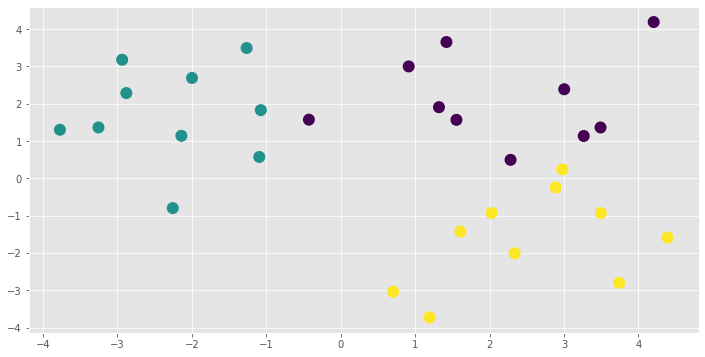

In [23]:
np.random.seed(123)
X = np.vstack([np.random.randn(10,2) + [2,2],
               np.random.randn(10,2) + [-2,2],
               np.random.randn(10,2) + [2,-2]])
Y = np.repeat(np.eye(3), 10, 0)

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,6)
plt.scatter(X[:,0], X[:,1], 100, np.argmax(Y, 1), lw=2, cmap=plt.cm.viridis);

In [24]:
m = LinearMulticlass(X, Y)
m

In [25]:
def closure(): 
    return - m.log_marginal_likelihood()

opt = gpflow.optimizers.Scipy()
opt.minimize(closure, variables=m.trainable_variables)

      fun: 1.2560984621424865e-05
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.28392990e-06,  1.15665823e-06, -5.44058813e-06, -2.77570188e-06,
        2.97110223e-06, -1.95400347e-07, -8.81900275e-07,  2.52856127e-06,
       -1.64666099e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 27
      nit: 26
   status: 0
  success: True
        x: array([  8.55849743, -30.63655328,  22.4144818 ,  23.79332963,
        21.27896803, -44.17402754,  11.85784428, -12.94743432,
        -0.29631308])

In [26]:
xx, yy = np.mgrid[-4:4:200j, -4:4:200j]
X_test = np.vstack([xx.flatten(), yy.flatten()]).T
f_test = np.dot(X_test, m.W.read_value()) + m.b.read_value()
p_test = np.exp(f_test)
p_test /= p_test.sum(1)[:,None]

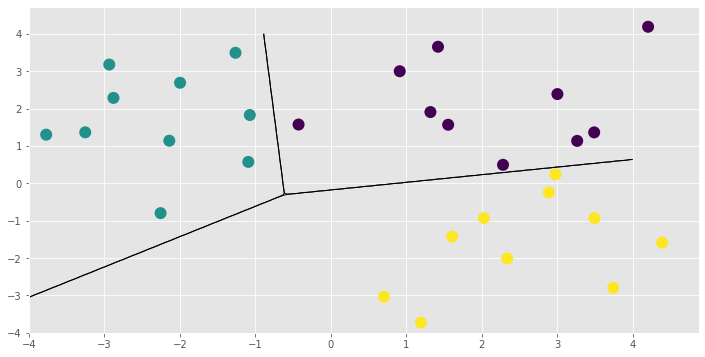

In [27]:
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.contour(xx, yy, p_test[:,i].reshape(200,200), [0.5], colors='k', linewidths=1)
plt.scatter(X[:,0], X[:,1], 100, np.argmax(Y, 1), lw=2, cmap=plt.cm.viridis);

That concludes the new model example and this notebook. You might want to see for yourself that the `LinearMulticlass` model and its parameters have all the functionality demonstrated here. You could also add some priors and run Hamiltonian Monte Carlo using the HMC optimizer `gpflow.train.HMC` and its `sample` method. See [Markov Chain Monte Carlo (MCMC)](../advanced/mcmc.ipynb) for more information on running the sampler.